### <div style="text-align: left"> Izradila: Filipa Lovrić </div>
# <div style="text-align: center"> Projektni zadatak iz Umjetne Inteligencije </div>
## <div style="text-align: center"> Lovac na blago (otvoreni minesweeper) </div>



## Tekst zadatka:

Lovac na blago metalnim je detektorom pronašao novčiće. Nije ih imao vremena iskopati, pa je
napravio kartu nalazišta u nadi da je, čak iako je izgubi, nitko neće razumjeti. U poljima koja sadrže
brojeve nema novčića, ali ti brojevi ukazuju na to koliko se novčića nalazi u 8 polja koja ih okružuju. U
polju se nalazi točno jedan novčić. Otkrijte točan broj i položaj novčića metodama pretraživanja u
dubinu i širinu i algoritmom A* s proizvoljno odabranom heuristikom. Usporedite složenost upotrijebljenih metoda.

#### Korišteni moduli:

In [1]:
import sys
print("Python version: ", sys.version)
print ("Version info: ", sys.version_info)

Python version:  3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]
Version info:  sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)


In [2]:
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

from collections import deque
from IPython.display import clear_output, display
from matplotlib.table import Table
from queue import PriorityQueue
from typing import Any, Dict, List, Optional, Tuple

In [3]:
print(f"Matplotlib version: {matplotlib.__version__}, \nBackend: {matplotlib.get_backend()}")

Matplotlib version: 3.2.2, 
Backend: module://ipykernel.pylab.backend_inline


## 1. Zapis karata:

Karte s blagom pohranjujemo u obliku cjelobrojnih matrica.  
Brojevi od 0-8 označavaju broj okolnih polja s novčićima.  
Broj 9 označava prazno polje, broj 10 označava polje s novčićem, dok broj 11 označava polje na kojemu ne može biti novčić.

In [4]:
E = 9
G = 10
CHECKED = 11
divider = ""

In [5]:
def get_matrix_example_one():
    matrix = \
    [
        [E,E,E,E,E,E,2,E,2,E],
        [E,0,1,E,E,3,4,E,3,E],
        [E,0,E,1,E,E,E,E,4,E],
        [E,E,E,E,1,E,E,E,E,2],
        [2,E,E,E,E,E,E,3,2,E],
        [E,E,4,E,E,E,2,3,E,E],
        [2,E,E,0,E,E,E,E,E,E],
        [2,E,E,2,1,E,3,4,4,E],
        [E,E,E,E,E,E,E,3,E,E],
        [E,2,1,2,E,E,3,E,2,E]
    ]
    return matrix

def get_matrix_example_two():
    matrix = \
    [
        [E,E,E,E,E,E,E,E,E,E],
        [0,E,1,E,1,E,E,1,2,1],
        [0,E,E,2,E,1,E,0,E,1],
        [E,E,E,E,E,1,2,E,3,E],
        [1,E,E,3,E,E,E,E,E,E],
        [E,E,E,E,1,3,E,3,E,1],
        [2,E,2,E,E,E,E,E,E,E],
        [E,E,E,E,3,E,3,2,E,E],
        [2,E,E,E,6,E,E,3,E,1],
        [E,0,E,E,E,E,4,E,E,E]
    ]
    return matrix

## 2. Pomoćne funkcije

Za vizualizaciju koristimo _matplotlib.pyplot_ modul s defaultnim jupyterovim _ipykernel.pylab.backend_inline_ backendom.  
Karta s blagom prikazuje se u obliku tablice te se za svako polje na karti kreira po jedna čelija.

### Funkcije korištene za vizualizaciju:

 *add_cell_to_table*  


- Funkcija za dodavanje čelije u tablicu. Ukoliko polje sadrži novčić, pozadinska boja čelije postavlja se u zlatnu boju.


*update_matrix_figure* 


- Funkcija prima matricu. Ažurira trenutno otvoreni plt.axes objekt s tablicom koja predstavlja dohvaćenu matricu. Ukoliko se izvršava real-time vizualizacija, funkcija ispisuje trenutni korak u vizualizaciji.


*plot_matrix*  


- Funkcija prikazuje dohvaćenu matricu.


*with_numbers*


- Funkcija prima riješenu matricu i originalnu matricu. Vraća brojeve od 1 do 8 iz originalne matrice u riješenu matricu.

In [6]:
def add_cell_to_table(x, y, width, height, state, table):
    if state == E:
        table.add_cell(x, y, width, height, text="")
    elif state == G:
        table.add_cell(x, y, width, height, facecolor='#FFD700')
    elif state == CHECKED:
        table.add_cell(x, y, width, height, facecolor='white')
    elif 0 <= state <= 8:
        table.add_cell(x, y, width, height, text=state, loc='center')
        
def update_matrix_figure(matrix, fig, ax, step=0, maxsteps=0):
    ax.clear()
    ax.set_axis_off()
    if maxsteps != 0:
        ax.set_title('Step: {} / {}'.format(step,maxsteps))
    
    nrows, ncols = get_matrix_size(matrix)
    height, width = 1 / nrows, 1 / ncols
    
    tb = Table(ax, bbox=[0,0,1,1])
    for (x,y), state in np.ndenumerate(matrix):
        add_cell_to_table(x, y, width, height, state, tb)  
    ax.add_table(tb)
    
def plot_matrix(matrix: List[List[int]]):
    fig = plt.figure(figsize=(5,5), dpi=80)
    axes = fig.add_axes([0,0,1,1])
    update_matrix_figure(matrix, fig, axes)
    plt.show()
    plt.close()

def with_numbers(matrix: List[List[int]],
                 original: List[List[int]]):
    for x in range(0, len(original)):
        for y in range(0, len(original[x])):
            if 0 <= original[x][y] <= 8:
                matrix[x][y] = original[x][y]
    return matrix

### Funkcije korištene u DFS, BFS, A* algoritmima:

*get_matrix_size*  


- Funkcija prima matricu. Vraća dimenzije matrice u obliku (int, int).


*idx_is_in_matrix*


- Funkcija prima matricu i indeks (int, int). Vraća True ako se navedeni indeks nalazi unutar dimenzija matrice. U suprotnom, vraća False.



*get_neighbour_indexes*  


- Funkcija prima indeks (int, int) i dimenzije matrice (int, int). Vraća listu svih indeksa oko navedenog, koji se nalaze unutar dimenzija matrice.


*get_field_to_decrement*


- Funkcija prima matricu. Nalazi prvo polje u matrici oko kojega se nalazi novčić. Ukoliko takvo polje ne postoji, vraća (-1, -1).


*move_checked_around_field*


- Funkcija prima matricu i indeks. Na svako mjesto oko navedenog indeksa, gdje je u matrici E (Empty), stavlja CHECKED (polje na kojem ne može biti novčić).


*check_if_matrix_correct*


- Funkcija prima matricu. Vraća False ukoliko se u matrici nalazi polje s većim brojem okolnih blaga od broja okolnih praznih polja. U suprotnom, vraća True.


*insert_gold_in_matrix*


- Funkcija prima matricu i poziciju novčića. Funkcija stavlja novčić na navedenu poziciju. Sve brojeve od 1 do 8 oko novčića dekrementira.


*count_number_sum*


- Funkcija prima matricu i vraća zbroj brojeva od 1 do 8 u matrici. Korištena je kao heuristika u A* algoritmu.

In [7]:
def get_matrix_size(matrix: List[List[int]]):
    return (len(matrix), len(matrix[0]))

def idx_is_in_matrix(matrix: List[List[int]],
                     idx: Tuple[int, int]):
    try:
        a = matrix[idx[0], idx[1]]
    except IndexError:
        return False
    return True

def get_neighbour_indexes(idx: Tuple[int, int], 
                          matrix_size: Tuple[int, int]):
    return [(x, y) for x in range(idx[0]-1, idx[0]+2) for y in range(idx[1]-1, idx[1]+2) 
            if (-1 < x < matrix_size[0] and 
                -1 < y < matrix_size[1] and 
                (x != idx[0] or y != idx[1]))]

def get_field_to_decrement(matrix: List[List[int]]):
    for x in range(0, len(matrix)):
        for y in range(0, len(matrix[x])):
            if 1 <= matrix[x][y] <= 8:
                return (x,y)
    return (-1,-1)

def move_checked_around_field(matrix: List[List[int]], 
                              index: Tuple[int, int]):
    for field in get_neighbour_indexes(index, get_matrix_size(matrix)):
        if matrix[field[0]][field[1]] is E:
            matrix[field[0]][field[1]] = CHECKED
    matrix[index[0]][index[1]] = CHECKED
    
def check_if_matrix_correct(matrix: List[List[int]]):
    for x in range(0, len(matrix)):
        for y in range(0,len(matrix[x])):
            if 1 <= matrix[x][y] <= 8:
                if len([index for index in get_neighbour_indexes((x,y), get_matrix_size(matrix)) if
                        matrix[index[0]][index[1]] == E]) < matrix[x][y]:
                    return False
    return True

def insert_gold_in_matrix(matrix: List[List[int]], 
                          field: Tuple[int, int]):
    to_push = copy.deepcopy(matrix)
    to_push[field[0]][field[1]] = G
    
    for field_around_gold in [around for around in get_neighbour_indexes(field, get_matrix_size(to_push)) if
                              1 <= to_push[around[0]][around[1]] <= 8]:
        to_push[field_around_gold[0]][field_around_gold[1]] -= 1
        if to_push[field_around_gold[0]][field_around_gold[1]] == 0:
            move_checked_around_field(to_push, field_around_gold)
    return to_push

def count_number_sum(matrix: List[List[int]]):
    count = 0
    for row in matrix:
        for field in row:
            count = count + field if 1 <= field <= 8 else count
    return count


### Pomoćna funkcija za sažeti ispis algoritma:


*print_execution_time*


- Funkcija prima algoritam i neriješenu matricu. Ispisuje vrijeme i broj koraka potreban za dobivanje rješenja matrice navedenim algoritmom.

In [8]:
def print_execution_time(algorithm, matrix, example_name="example"):
    start_time = time.time()
    (steps, throw) = algorithm(matrix)
    print(f"Time to execute {example_name} using {algorithm.__name__}: {round(time.time() - start_time, 3)}s, number of steps: {steps}")

## 3. DFS, BFS i A* algoritmi

### DFS


DFS algoritam sprema originalnu matricu u stog. Za stog je korištena **python list** struktura. 

Dok stog nije prazan, DFS algoritam:
- uzima matricu s vrha stoga
- provjerava je li dohvaćena matrica rješenje
- nalazi prvu brojku (1-8) u matrici
- na svako prazno polje oko navedene brojke stavlja novčić 
- dekrementira brojeve oko novčića
- deepcopy matrice stavlja na vrh stoga

In [9]:
def DFS(matrix: List[List[int]], 
        visualization: bool = 0,
        max_steps: int = 0,
        fig = None, axes = None):
    
    stack = []
    first = copy.deepcopy(matrix)
    
    for x in range(0, len(first)):
        for y in range(0, len(first[0])):
            if first[x][y] == 0:
                move_checked_around_field(first, (x,y))
    stack.append(first)
    num_steps = -1

    while(len(stack)):
        mtrx = stack.pop()
        num_steps += 1
        
        if visualization and num_steps <= max_steps:
            plt.cla()
            clear_output(wait=True)
            update_matrix_figure(mtrx, fig, axes, num_steps, max_steps)
            display(plt.gcf())
            time.sleep(0.25)
        
        index = get_field_to_decrement(mtrx)
        if index == (-1, -1):
            for x in range(0, len(mtrx)):
                for y in range(0, len(mtrx[x])):
                    if mtrx[x][y] == E:
                        mtrx[x][y] = CHECKED
            return (num_steps, mtrx)
        
        neighbours = get_neighbour_indexes(index, get_matrix_size(mtrx))
        for neighbour in neighbours:
            if mtrx[neighbour[0]][neighbour[1]] is E:
                to_push = insert_gold_in_matrix(mtrx, neighbour)
                if check_if_matrix_correct(mtrx) is False:
                    continue
                stack.append(copy.deepcopy(to_push))
    
    print("Error, could not solve given matrix")
    return (0, matrix)

### BFS


BFS algoritam sprema originalnu matricu u red. Za red je korištena **collections.deque** struktura.

Dok red nije prazan, BFS algoritam:
- uzima matricu s početka reda
- provjerava je li dohvaćena matrica rješenje
- nalazi prvu brojku (1-8) u matrici
- na svako prazno polje oko navedene brojke stavlja novčić
- dekrementira brojeve oko novčića
- deepcopy matrice stavlja na kraj reda

In [10]:
def BFS(matrix: List[List[int]], 
        visualization: bool = 0,
        max_steps: int = 0,
        fig = None, axes = None):
    
    queue = deque([])
    first = copy.deepcopy(matrix)
    
    for x in range(0, len(first)):
        for y in range(0, len(first[0])):
            if first[x][y] == 0:
                move_checked_around_field(first, (x,y))
    queue.append(first)
    num_steps = -1

    while(len(queue)):
        mtrx = queue.popleft()
        num_steps += 1
        
        if visualization and num_steps <= max_steps:
            plt.cla()
            clear_output(wait=True)
            update_matrix_figure(mtrx, fig, axes, num_steps, max_steps)
            display(plt.gcf())
            time.sleep(0.25)
        
        index = get_field_to_decrement(mtrx)
        if index == (-1, -1):
            for x in range(0, len(mtrx)):
                for y in range(0, len(mtrx[x])):
                    if mtrx[x][y] == E:
                        mtrx[x][y] = CHECKED
            return (num_steps, mtrx)
        
        neighbours = get_neighbour_indexes(index, get_matrix_size(mtrx))
        for neighbour in neighbours:
            if mtrx[neighbour[0]][neighbour[1]] is E:
                to_push = insert_gold_in_matrix(mtrx, neighbour)
                if check_if_matrix_correct(mtrx) is False:
                    continue
                queue.append(copy.deepcopy(to_push))
    
    print("Error, could not solve given matrix")
    return (0, matrix)

### A*


A* algoritam sprema originalnu matricu u prioritetni red. Za prioritetni red je korištena **queue.PriorityQueue** struktura.

Dok prioritetni red nije prazan, A* algoritam:
- uzima matricu s početka prioritetnog reda
- provjerava je li dohvaćena matrica rješenje
- nalazi prvu brojku (1-8) u matrici
- na svako prazno polje oko navedene brojke stavlja novčić
- dekrementira brojeve oko novčića
- deepcopy matrice stavlja u prioritetni red*


\**Matrica se natrag u prioritetni red šalje u paru s izračunatom procjenom udaljenosti do kraja. Tu procjenu vrši funkcija count_number_sum te se po njoj određuje prioritet matrice u redu. Matrice s najmanjim zbrojem brojeva od 1 do 8 stavljaju se na početak reda. Ovako odabrana heuristika prioritizira matrice u kojima su novčići stavljeni na pozicije između što više brojeva.*

In [11]:
def Astar(matrix: List[List[int]], 
          visualization: bool = 0,
          max_steps: int = 0,
          fig = None, axes = None):
    
    queue = PriorityQueue()
    first = copy.deepcopy(matrix)
    
    for x in range(0, len(first)):
        for y in range(0, len(first[0])):
            if first[x][y] == 0:
                move_checked_around_field(first, (x,y))
    queue.put((count_number_sum(first), first))
    num_steps = -1

    while not queue.empty():
        (throw, mtrx) = queue.get()
        num_steps += 1
        
        if visualization and num_steps <= max_steps:
            plt.cla()
            clear_output(wait=True)
            update_matrix_figure(mtrx, fig, axes, num_steps, max_steps)
            display(plt.gcf())
            time.sleep(0.25)
        
        index = get_field_to_decrement(mtrx)
        if index == (-1, -1):
            for x in range(0, len(mtrx)):
                for y in range(0, len(mtrx[x])):
                    if mtrx[x][y] == E:
                        mtrx[x][y] = CHECKED
            return (num_steps, mtrx)
        
        neighbours = get_neighbour_indexes(index, get_matrix_size(mtrx))
        for neighbour in neighbours:
            if mtrx[neighbour[0]][neighbour[1]] is E:
                to_push = insert_gold_in_matrix(mtrx, neighbour)
                if check_if_matrix_correct(mtrx) is False:
                    continue
                queue.put((count_number_sum(to_push), copy.deepcopy(to_push)))
    
    print("Error, could not solve given matrix")
    return (0, matrix)

## 4. Stablo pretraživanja i brzina algoritama

**Stabla pretraživanja, dubina i širina**  
Neka je _N_ broj novčića u konačnom rješenju. Tada je (zbog funkcije *check_if_matrix_correct*) maksimalna dubina stabla pretraživanja očito jednaka *N+1*.  
Djeca pojedinog čvora stabla dobivaju se pomoću funkcije *get_neighbour_indexes* za prvi pronađeni broj u matrici te izbacivanjem susjednih polja koja nisu prazna. Stoga je širina svake razine stabla manja ili jednaka od 8\*(*širina prethodne razine stabla*). U stvarnosti, širina je puno manja od navedene.  


&nbsp;

Razlozi zašto kandidate tražimo putem *get_neighbour_indexes* za prvi pronađeni broj umjesto da stavimo po jedan zlatnik na svako prazno mjesto u matrici:
- maksimalno _8\*(širina prethodne razine stabla)_ čvorova na novoj razini naspram _a\*(širina prethodne razine stabla)_ čvorova, gdje je *a* jednak broju preostalih praznih polja u matrici
- omogućuje rješavanje primjera poput 10x10 matrice sa jednom osmicom u sredini i ostalih 99 polja neispunjeno (stavljanje zlata jedno po jedno na svako mjesto u matrici bi izbacilo matricu s 99 zlata kao konačno rješenje)

In [12]:
pr1 = get_matrix_example_one()
pr2 = get_matrix_example_two()

In [13]:
%%time
print_execution_time(DFS, pr1, "pr1")
print_execution_time(DFS, pr2, "pr2")
print(divider)
print_execution_time(BFS, pr1, "pr1")
print_execution_time(BFS, pr2, "pr2")
print(divider)
print_execution_time(Astar, pr1, "pr1")
print_execution_time(Astar, pr2, "pr2")
print(divider)

Time to execute pr1 using DFS: 0.89s, number of steps: 5853
Time to execute pr2 using DFS: 0.244s, number of steps: 1523

Time to execute pr1 using BFS: 4.507s, number of steps: 29546
Time to execute pr2 using BFS: 0.425s, number of steps: 2725

Time to execute pr1 using Astar: 2.91s, number of steps: 5852
Time to execute pr2 using Astar: 0.704s, number of steps: 1195

Wall time: 9.68 s


**Broj koraka i brzina algoritama**

Zbog toga što je konačno rješenje na najnižoj razini stabla pretraživanja, BFS će u svakome slučaju trebati više koraka od DFS i A\*. Ovisno o primjeru, A\* može imati bolje ili lošije rezultate od DFS algoritma. No, za očekivati je da će naša odabrana heuristika pozitivno utjecati na smanjenje broja koraka u programu, što se na testnim primjerima i pokazalo.

&nbsp;

Brzina izvršavanja programa ne ovisi samo o broju koraka, nego i o strukturi koju koristimo. U slučajevima u kojima DFSu i A* treba podjednaki broj koraka, DFS će biti brži zbog razlike u brzini između stoga i prioritetnog reda. Iako je običan red brži od prioritetnog, zbog puno većeg broja koraka, BFS će uvijek biti sporiji od DFS i A* algoritama.

## 5. Vizualizacija rješenja i koraka

Uvjeravamo se da naši algoritmi izbacuju točno konačno rješenje:

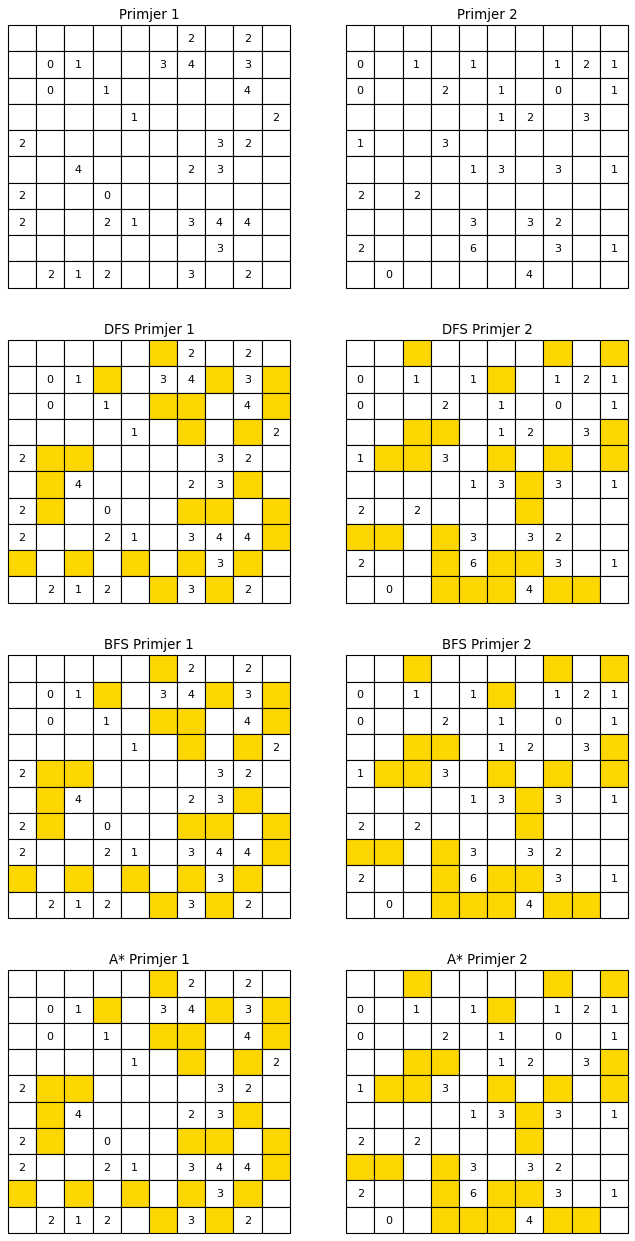

Wall time: 32 s


In [14]:
%%time
pr1 = get_matrix_example_one()
pr2 = get_matrix_example_two()

fig, axes = plt.subplots(4, 2, figsize=(10,20), dpi=80)

update_matrix_figure(pr1, fig, axes[0][0])
update_matrix_figure(pr2, fig, axes[0][1])

update_matrix_figure(with_numbers(DFS(pr1)[1], pr1), fig, axes[1][0])
update_matrix_figure(with_numbers(DFS(pr2)[1], pr2), fig, axes[1][1])

update_matrix_figure(with_numbers(BFS(pr1)[1], pr1), fig, axes[2][0])
update_matrix_figure(with_numbers(BFS(pr2)[1], pr2), fig, axes[2][1])

update_matrix_figure(with_numbers(Astar(pr1)[1], pr1), fig, axes[3][0])
update_matrix_figure(with_numbers(Astar(pr2)[1], pr2), fig, axes[3][1])

axes[0][0].set_title("Primjer 1")
axes[0][1].set_title("Primjer 2")

axes[1][0].set_title("DFS Primjer 1")
axes[1][1].set_title("DFS Primjer 2")

axes[2][0].set_title("BFS Primjer 1")
axes[2][1].set_title("BFS Primjer 2")

axes[3][0].set_title("A* Primjer 1")
axes[3][1].set_title("A* Primjer 2")

plt.show()

### Korak po korak

U sljedeće 3 čelije, vizualiziramo DFS, BFS i A* algoritme. Budući da bi vizualizacija više tisuća koraka predugo trajala, pokazujemo rad algoritama samo nad prvih 30 koraka.  

&nbsp;

**Za pokretanje pojedinog algoritma, korisnik treba promijeniti tip čelije s "Raw NBConvert" u "Code"**.

#### DFS

#### BFS

#### A*